In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

sys.path.append('../scripts/')

import utils
from utils import read_ss_file

In [2]:
GQUAD_ANNOT_PATH = '../data/ideal_table_with_Gquadr.csv'
SEC_STRUCT_PATH = "../data/structure_data/SARSCoV2-RNA_from_site_plus_0based.ss"

In [3]:
gannotation = pd.read_csv(GQUAD_ANNOT_PATH)
ss_regions = read_ss_file(SEC_STRUCT_PATH)

/home/mr/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## G-quadruplexes

In [4]:
gpositions = gannotation.groupby('Pos').Quadr.min()[
                gannotation.groupby('Pos').Quadr.min() == 1].index.values - 1  # 0-based
gpositions.shape

(216,)

In [5]:
# positions of the regions (stems + free)
ss_positions = []
for ss in ss_regions:
    start, end = ss[1:3]
    for pos in range(start, end + 1):
        ss_positions.append(pos)
ss_positions = np.array(ss_positions)

In [6]:
ss_positions.shape[0]

6134

In [7]:
print(
    len(gpositions) - len(set(gpositions).difference(ss_positions)), 
    'Gquadr-positions is in ss regions'
)

48 Gquadr-positions is in ss regions


In [8]:
ss_positions

array([   83,    84,    85, ..., 29864, 29865, 29866])

In [9]:
df = pd.read_csv('../data/secondary_structure_on_genome.csv')
df[df.IsStem == 1].head()

,Pos,RefNuc,GenName,IsStem,SsPairs
83,84,C,5UTR,1.0,126.0
84,85,T,5UTR,1.0,125.0
85,86,G,5UTR,1.0,124.0
86,87,T,5UTR,1.0,123.0
87,88,G,5UTR,1.0,122.0


In [10]:
stem_positions = []
for ss in ss_regions:
    start = ss[1]
    pairs = ss[4]
    for pos in pairs:
        pos += start
        stem_positions.append(pos)

In [11]:
_ = 1150
stem_positions[_:_ + 10]

[7959, 7960, 7961, 7962, 7967, 7968, 7970, 7971, 7972, 7973]

In [12]:
df[df.IsStem == 1].iloc[_:_ + 10]

,Pos,RefNuc,GenName,IsStem,SsPairs
7959,7960,G,ORF1ab,1.0,8098.0
7960,7961,T,ORF1ab,1.0,8097.0
7961,7962,G,ORF1ab,1.0,8096.0
7962,7963,T,ORF1ab,1.0,8095.0
7967,7968,C,ORF1ab,1.0,8017.0
7968,7969,T,ORF1ab,1.0,8016.0
7970,7971,T,ORF1ab,1.0,8014.0
7971,7972,A,ORF1ab,1.0,8013.0
7972,7973,C,ORF1ab,1.0,8012.0
7973,7974,T,ORF1ab,1.0,8011.0


## TRS
[paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7094943/)
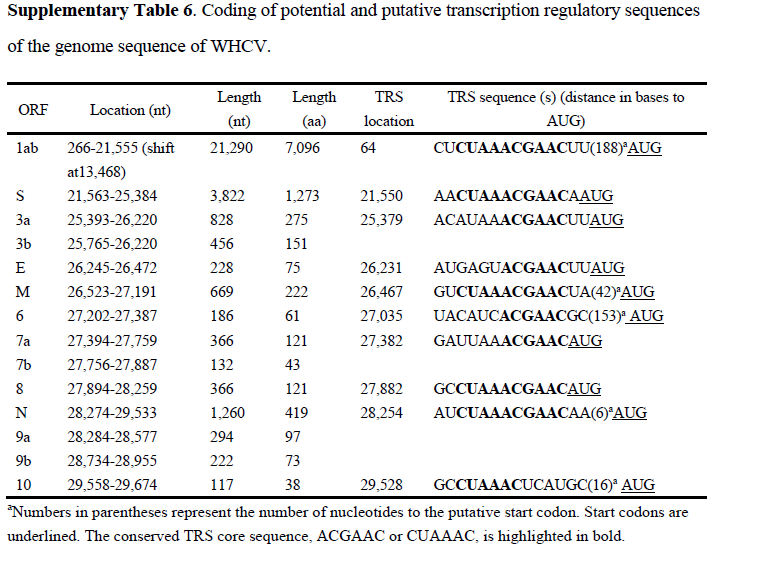
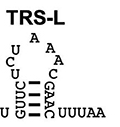

In [13]:
trs_intervals = [
    (64, 64 + 14),
    (21550, 21550 + 14),
    (25379, 25379 + 14),  # obtained
    (26231, 26231 + 14),  # obtained
    (26467, 26467 + 14),
    (27035, 27035 + 14),  # obtained
    (27382, 27382 + 14),
    (27882, 27882 + 14),
    (28254, 28254 + 14),
    (29528, 29528 + 14),
]
trs_positions = [x for p1, p2 in trs_intervals for x in range(p1, p2)]

In [14]:
len(set(trs_positions).difference(ss_positions)), len(trs_positions)

(98, 140)

In [15]:
df['IsTRS'] = 0
df['IsTRS'][df.Pos.isin(trs_positions)] = 1

/home/mr/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
df.IsTRS.sum()

140

### We have only 41 position in 3 regions from 9 TRS

### Check the mutation rate on TRS

In [17]:
from utils import read_fasta_generator

SUBSTITUTIONS_PATH = '../data/overall_mutations_with_context2.json'
REFSEQ_PATH = "../data/covid_ref.fasta"

refseq = next(read_fasta_generator(REFSEQ_PATH))[1].replace('\n', '')
print(len(refseq))

with open(SUBSTITUTIONS_PATH) as fin:
    substitutions = json.load(fin)
    

refseq_len = len(refseq)
subs_by_pos = [[] for _ in range(refseq_len)]
n_overall_substitutions = 0
n_snps = 0

for parent_node, child_node, substs in substitutions:
    for pos, parent_nucl, child_nucl, _, _ in substs:
        n_overall_substitutions += 1
        # only SNPs
        if parent_nucl != '-' and child_nucl != '-':
            subs_by_pos[pos].append((parent_nucl, child_nucl, ))  # parent_node, child_node
            n_snps += 1

assert n_snps == sum(map(len, subs_by_pos))

print(f'{n_overall_substitutions} substitutions in the dataset')
print(f"{n_snps} SNPs (not indel)")

29903
631407 substitutions in the dataset
618118 SNPs (not indel)


In [18]:
nsubs_by_pos = np.array(list(map(len, subs_by_pos)))
nsubs_by_pos.shape

(29903,)

In [19]:
df['NSubst'] = nsubs_by_pos
# df.to_csv('../data/gemone_structures_annot.csv', index=None)

In [20]:
df[df.Pos.isin(np.arange(*trs_intervals[0]))]

,Pos,RefNuc,GenName,IsStem,SsPairs,IsTRS,NSubst
63,64,C,5UTR,NaN,NaN,1,42
64,65,T,5UTR,NaN,NaN,1,0
65,66,C,5UTR,NaN,NaN,1,387
66,67,T,5UTR,NaN,NaN,1,4
67,68,A,5UTR,NaN,NaN,1,0
68,69,A,5UTR,NaN,NaN,1,0
69,70,A,5UTR,NaN,NaN,1,0
70,71,C,5UTR,NaN,NaN,1,0
71,72,G,5UTR,NaN,NaN,1,0
72,73,A,5UTR,NaN,NaN,1,0


In [23]:
for start, end in trs_intervals:
    print(nsubs_by_pos[start: end])

[  0 387   4   0   0   0   0   0   0   0  20  10   0  30]
[86 45  0  0  8 16  0  0  0  0  4  5  0  0]
[ 8 14  1  0  8  0 42  0  0  0  4  4 12  0]
[ 4 96 19  4  0  8  0  4  0  0  0  0  0  0]
[  0 109   0   0   4   0   0   0   0   0   4   0   0   0]
[  0   0   9   8   4   4   0   0   4   0 156 145   0   0]
[160 722   0   8   9   0 186  93   4  37  74   8   0  13]
[82 12  0  0  0  1 76 66  1  0 17 16  2  4]
[  5 326   0   0   0   0   0   0   0   4   4  18   0   0]
[  8  66   0   4   4  12  37   0   4  68   4  86 286   4]


In [24]:
nsubs_by_pos[trs_positions]

array([  0, 387,   4,   0,   0,   0,   0,   0,   0,   0,  20,  10,   0,
        30,  86,  45,   0,   0,   8,  16,   0,   0,   0,   0,   4,   5,
         0,   0,   8,  14,   1,   0,   8,   0,  42,   0,   0,   0,   4,
         4,  12,   0,   4,  96,  19,   4,   0,   8,   0,   4,   0,   0,
         0,   0,   0,   0,   0, 109,   0,   0,   4,   0,   0,   0,   0,
         0,   4,   0,   0,   0,   0,   0,   9,   8,   4,   4,   0,   0,
         4,   0, 156, 145,   0,   0, 160, 722,   0,   8,   9,   0, 186,
        93,   4,  37,  74,   8,   0,  13,  82,  12,   0,   0,   0,   1,
        76,  66,   1,   0,  17,  16,   2,   4,   5, 326,   0,   0,   0,
         0,   0,   0,   0,   4,   4,  18,   0,   0,   8,  66,   0,   4,
         4,  12,  37,   0,   4,  68,   4,  86, 286,   4])

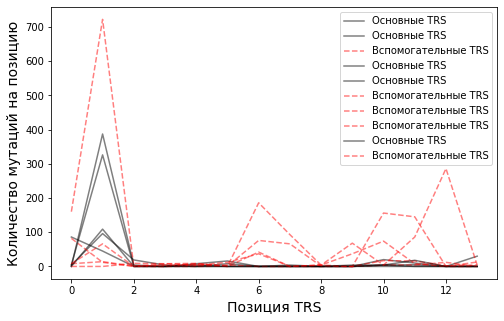

In [32]:
plt.figure(figsize=(8, 5))

for i, (start, end) in enumerate(trs_intervals):
    if i in [0, 1, 3, 4, 8]:
        lbl = 'Основные TRS'
        stl = 'k'
    else:
        lbl = 'Вспомогательные TRS'
        stl = 'r--'
    plt.plot(nsubs_by_pos[start: end], stl, label=lbl, alpha=.5)
plt.legend()
plt.xlabel('Позиция TRS', fontsize=14)
plt.ylabel('Количество мутаций на позицию', fontsize=14)
plt.show()

### Add 

In [6]:
GENES_ANNOT_PATH = '../data/genes_annotation.csv'

genes = pd.read_csv(GENES_ANNOT_PATH)
genes['Pos'] -= 1

In [8]:
genes.head(2)

,Pos,RefNuc,GenName
0,0,A,5UTR
1,1,T,5UTR


In [31]:
genes[trs_intervals[0][0]: trs_intervals[0][1]]

,Pos,RefNuc,GenName
64,64,T,5UTR
65,65,C,5UTR
66,66,T,5UTR
67,67,A,5UTR
68,68,A,5UTR
69,69,A,5UTR
70,70,C,5UTR
71,71,G,5UTR
72,72,A,5UTR
73,73,A,5UTR


In [100]:
gene_names = [c for c in genes.GenName.unique() if '_' not in c]
gend_pos = genes[genes.GenName.isin(gene_names)].groupby('GenName').Pos.max()
gend_pos

GenName
3UTR      29902
5UTR        264
E         26471
M         27190
N         29532
ORF10     29673
ORF1ab    21554
ORF3a     26219
ORF6      27386
ORF7a     27754
ORF7b     27886
ORF8      28258
S         25383
Name: Pos, dtype: int64

In [101]:
from utils import print_ss_fasta_to_draw

In [111]:
print_ss_fasta_to_draw(ss_regions, 65)

>motif_23969-24097
CACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTG
((..(((((((((((...............(((((..((((((..(((((((.....)))))))...)))))).))))).......(((.((((((.......))))))..))))))))))))))..))
